In [3]:
"""  Intelligent energy component contains the IEC class, that includes several algorithms
     for predicting consumption of a house, given historical data. It also contains an IECTester
     class that can be used to test and provide results on multiple IEC runs """

from __future__ import division

import pickle
from datetime import timedelta
from functools import partial
from multiprocessing import Pool, cpu_count

import numpy as np
import statsmodels.api as sm
import pandas as pd
import scipy.ndimage.filters
import scipy.signal
from scipy import spatial
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import random

import GPy

try:
    from .easing import *
except:
    from easing import *

cons_col = 'House Consumption'


class NoSimilarMomentsFound(Exception):
    pass


def cosine_similarity(a, b):
    """Calculate the cosine similarity between
    two non-zero vectors of equal length (https://en.wikipedia.org/wiki/Cosine_similarity)
    """
    return 1.0 - spatial.distance.cosine(a, b)


def baseline_similarity(a, b, filter=True):
    if filter is True:
        similarity = -mean_squared_error(gauss_filt(a, 201), gauss_filt(b, 201)) ** 0.5
    else:
        similarity = -mean_squared_error(a, b) ** 0.5
    return similarity


def advanced_similarity(a, b):
    sigma = 10

    base_similarity = baseline_similarity(a, b)

    high_pass_a = highpass_filter(a)
    high_pass_b = highpass_filter(b)

    high_pass_a = scipy.ndimage.filters.gaussian_filter1d(high_pass_a, sigma)
    high_pass_b = scipy.ndimage.filters.gaussian_filter1d(high_pass_b, sigma)

    highpass_similarity = -mean_squared_error(high_pass_a, high_pass_b)

    return base_similarity + highpass_similarity


def mins_in_day(timestamp):
    return timestamp.hour * 60 + timestamp.minute


def find_similar_days(training_data, observation_length, k, interval, method=cosine_similarity):
    now = training_data.index[-1]
    timezone = training_data.index.tz

    # Find moments in our dataset that have the same hour/minute and is_weekend() == weekend.
    # Those are the indexes of those moments in TrainingData

    min_time = training_data.index[0] + timedelta(minutes=observation_length)

    selector = (
        (training_data.index.minute == now.minute) &
        (training_data.index.hour == now.hour) &
        (training_data.index > min_time)
    )
    similar_moments = training_data[selector][:-1].tz_convert('UTC')

    if similar_moments.empty:
        raise NoSimilarMomentsFound

    training_data = training_data.tz_convert('UTC')

    last_day_vector = (training_data
                       .tail(observation_length)
                       .resample(timedelta(minutes=interval))
                       .sum()
                       )

    obs_td = timedelta(minutes=observation_length)

    similar_moments['Similarity'] = [
        method(
            last_day_vector.as_matrix(columns=[cons_col]),
            training_data[i - obs_td:i].resample(timedelta(minutes=interval)).sum().as_matrix(columns=[cons_col])
        ) for i in similar_moments.index
    ]

    indexes = (similar_moments
               .sort_values('Similarity', ascending=False)
               .head(k)
               .index
               .tz_convert(timezone))

    return indexes


def lerp(x, y, alpha):
    assert x.shape == y.shape and x.shape == alpha.shape  # shapes must be equal

    x *= 1 - alpha
    y *= alpha

    return x + y


def med_filt(x, k=201):
    """Apply a length-k median filter to a 1D array x.
    Boundaries are extended by repeating endpoints.
    """
    if x.ndim > 1:
        x = np.squeeze(x)
    med = np.median(x)
    assert k % 2 == 1, "Median filter length must be odd."
    assert x.ndim == 1, "Input must be one-dimensional."
    k2 = (k - 1) // 2
    y = np.zeros((len(x), k), dtype=x.dtype)
    y[:, k2] = x
    for i in range(k2):
        j = k2 - i
        y[j:, i] = x[:-j]
        y[:j, i] = x[0]
        y[:-j, -(i + 1)] = x[j:]
        y[-j:, -(i + 1)] = med
    return np.median(y, axis=1)


def gauss_filt(x, k=201):
    """Apply a length-k gaussian filter to a 1D array x.
    Boundaries are extended by repeating endpoints.
    """
    if x.ndim > 1:
        x = np.squeeze(x)
    med = np.median(x)
    assert k % 2 == 1, "mean filter length must be odd."
    assert x.ndim == 1, "Input must be one-dimensional."
    k2 = (k - 1) // 2
    y = np.zeros((len(x), k), dtype=x.dtype)
    y[:, k2] = x
    for i in range(k2):
        j = k2 - i
        y[j:, i] = x[:-j]
        y[:j, i] = x[0]
        y[:-j, -(i + 1)] = x[j:]
        y[-j:, -(i + 1)] = med
    return np.mean(y, axis=1)


def calc_baseline(training_data, similar_moments,
                  prediction_window, half_window=100, method=gauss_filt, interp_range=200):
    prediction_window_in_mins = prediction_window
    if type(prediction_window) is not timedelta:
        prediction_window = timedelta(minutes=prediction_window)

    k = len(similar_moments)

    r = np.zeros((prediction_window_in_mins + 1, 1))
    for i in similar_moments:
        r += (1 / k) * training_data[i:i + prediction_window].rolling(window=half_window * 2, center=True,
                                                                      min_periods=1).mean().as_matrix()
    baseline = np.squeeze(r)

    recent_baseline = training_data[-2 * half_window:-1].mean()[cons_col]

    if interp_range > 0:
        baseline[:interp_range] = lerp(np.repeat(recent_baseline, interp_range),
                                       baseline[:interp_range],
                                       np.arange(interp_range) / interp_range)

    return baseline


def calc_baseline_dumb(training_data, similar_moments,
                       prediction_window):
    if type(prediction_window) is not timedelta:
        prediction_window = timedelta(minutes=prediction_window)

    k = len(similar_moments)

    r = np.zeros((49, 1))
    for i in similar_moments:
        similar_day = (1 / k) * training_data[i:i + prediction_window].resample(timedelta(minutes=15)).mean()
        similar_day = similar_day[0:49]
        r += similar_day
        # r += (1 / k) * training_data[i:i + prediction_window].as_matrix

    baseline = np.squeeze(r)

    b = pd.DataFrame(baseline).set_index(pd.TimedeltaIndex(freq='15T', start=0, periods=49)).resample(
        timedelta(minutes=1)).ffill()
    baseline = np.squeeze(b.as_matrix())
    baseline = np.concatenate((baseline, np.atleast_1d(baseline[-1])))

    return baseline


def highpass_filter(a):
    cutoff = 2

    baseline = gauss_filt(a)
    highpass = a - baseline
    highpass[highpass < baseline * cutoff] = 0

    return highpass


def calc_highpass(training_data, similar_moments,
                  prediction_window, half_window, method=gauss_filt):
    if type(prediction_window) is not timedelta:
        prediction_window = timedelta(minutes=prediction_window)

    k = len(similar_moments)

    similar_data = np.zeros((k, int(prediction_window.total_seconds() / 60) + 2 * half_window))

    for i in range(k):
        similar_data[i] = training_data[
                          similar_moments[i] - timedelta(minutes=half_window)
                          : similar_moments[i] + prediction_window + timedelta(minutes=half_window),
                          2
                          ]

    highpass = np.apply_along_axis(highpass_filter, 1, similar_data)

    highpass = highpass[:, half_window: -half_window]

    w = 3
    confidence_threshold = 0.5

    paded_highpass = np.pad(highpass, ((0,), (w,)), mode='edge')

    highpass_prediction = np.zeros(prediction_window)

    for i in range(w, prediction_window + w):
        window = paded_highpass[:, i - w:i + w]
        confidence = np.count_nonzero(window) / window.size

        if confidence > confidence_threshold:
            highpass_prediction[
                i - w] = np.mean(window[np.nonzero(window)]) * confidence

    return highpass_prediction


class IEC(object):
    """The Intelligent Energy Component of a house.
    IEC will use several methods to predict the energy consumption of a house
    for a given prediction window using historical data.
    """

    def __init__(self, data, prediction_window=16 * 60):
        """Initializing the IEC.

        Args:
            :param data: Historical Dataset. Last value must be current time
        """
        self.data = data
        self.now = data.index[-1]
        self.prediction_window = prediction_window
        self.algorithms = {
            "Simple Mean": self.simple_mean,
            "Usage Zone Finder": self.usage_zone_finder,
            "ARIMA": self.ARIMAforecast,
            "Baseline Finder": partial(self.baseline_finder, training_window=1440 * 60, k=9, long_interp_range=250,
                                       short_interp_range=25, half_window=70, similarity_interval=5,
                                       recent_baseline_length=250,
                                       observation_length_addition=240, short_term_ease_method=easeOutSine,
                                       long_term_ease_method=easeOutCirc),
            "STLF": self.baseline_finder_dumb,
            "b1": partial(self.baseline_finder, training_window=1440 * 60, k=9, long_interp_range=250,
                          short_interp_range=25, half_window=70, similarity_interval=5, recent_baseline_length=250,
                          observation_length_addition=240, short_term_ease_method=easeOutSine,
                          long_term_ease_method=easeOutCirc),
            "b2": partial(self.baseline_finder, training_window=1440 * 60, k=3, long_interp_range=250,
                          short_interp_range=25, half_window=70, similarity_interval=5, recent_baseline_length=300,
                          observation_length_addition=240, short_term_ease_method=easeOutSine,
                          long_term_ease_method=easeOutCirc),
            "b3": partial(self.baseline_finder, training_window=1440 * 60, k=6, long_interp_range=250,
                          short_interp_range=25, half_window=70, similarity_interval=5, recent_baseline_length=200,
                          observation_length_addition=240, short_term_ease_method=easeOutSine,
                          long_term_ease_method=easeOutCirc),
            "b4": partial(self.baseline_finder, training_window=1440 * 60, k=12, long_interp_range=250,
                          short_interp_range=25, half_window=70, similarity_interval=5, recent_baseline_length=200,
                          observation_length_addition=240, short_term_ease_method=easeOutSine,
                          long_term_ease_method=easeOutCirc),
            "b5": partial(self.baseline_finder, training_window=1440 * 60, k=9, long_interp_range=250,
                          short_interp_range=25, half_window=50, similarity_interval=5, recent_baseline_length=250,
                          observation_length_addition=240, short_term_ease_method=easeOutSine,
                          long_term_ease_method=easeOutCirc),
            "b6": partial(self.baseline_finder, training_window=1440 * 60, k=9, long_interp_range=250,
                          short_interp_range=25, half_window=60, similarity_interval=5, recent_baseline_length=300,
                          observation_length_addition=240, short_term_ease_method=easeOutSine,
                          long_term_ease_method=easeOutCirc),
            "b7": partial(self.baseline_finder, training_window=1440 * 60, k=9, long_interp_range=250,
                          short_interp_range=25, half_window=80, similarity_interval=5, recent_baseline_length=200,
                          observation_length_addition=240, short_term_ease_method=easeOutSine,
                          long_term_ease_method=easeOutCirc),
            "Gaussian Process": gaussian_process(self.data, 'Timestamp (ns)', 'ciee/ devices/ meter/ 0xd8d5b9000000a110/ demand (Mean)', kernel='periodic')

        }

    def predict(self, alg_keys):
        index = pd.DatetimeIndex(start=self.now, freq='T', periods=self.prediction_window)
        result = pd.DataFrame(index=index)

        for key in alg_keys:
            r = self.algorithms[key]()
            if (r.shape[1] if r.ndim > 1 else 1) > 1:
                result[key] = r[:, 0]
                result[key + ' STD'] = r[:, 1]
            else:
                result[key] = r

        return result

    def simple_mean(self, training_window=24 * 60):
        training_data = self.data.tail(training_window)
        mean = training_data[cons_col].mean()
        return np.repeat(mean, self.prediction_window)

    def baseline_finder(self, training_window=1440 * 60, k=7, long_interp_range=300, short_interp_range=15,
                        half_window=100, similarity_interval=15, recent_baseline_length=200,
                        observation_length_addition=240, short_term_ease_method=easeOutQuad,
                        long_term_ease_method=easeOutQuad):
        training_data = self.data.tail(training_window)[[cons_col]]

        # observation_length is ALL of the current day (till now) + 4 hours
        observation_length = mins_in_day(self.now) + observation_length_addition

        try:
            similar_moments = find_similar_days(
                training_data, observation_length, k, similarity_interval, method=baseline_similarity)
        except NoSimilarMomentsFound:
            # no similar moments were found by our approach.. returning a mean of the last few hours
            recent_baseline = training_data[-recent_baseline_length:-1].mean()[cons_col]
            baseline = np.repeat(recent_baseline, self.prediction_window)
            baseline[0] = training_data.tail(1)[cons_col]
            return baseline

        baseline = calc_baseline(
            training_data, similar_moments, self.prediction_window, half_window, method=gauss_filt, interp_range=0)

        # long range interpolate

        interp_range = long_interp_range
        recent_baseline = training_data[-recent_baseline_length:-1].mean()[cons_col]

        method = np.array(list(map(lambda x: long_term_ease_method(x, 0, 1, interp_range), np.arange(interp_range))))

        if interp_range > 0:
            baseline[:interp_range] = lerp(np.repeat(recent_baseline, interp_range),
                                           baseline[:interp_range],
                                           method)

        # interpolate our prediction from current consumption to predicted
        # consumption
        # First index is the current time

        interp_range = short_interp_range
        current_consumption = training_data.tail(1)[cons_col]
        method = np.array(list(map(lambda x: short_term_ease_method(x, 0, 1, interp_range), np.arange(interp_range))))
        if interp_range > 0:
            baseline[:interp_range] = lerp(np.repeat(current_consumption, interp_range),
                                           baseline[:interp_range],
                                           method)

        return baseline[:-1]  # slice last line because we are actually predicting PredictionWindow-1

    def baseline_finder_dumb(self, training_window=1440 * 60, k=7):
        training_data = self.data.tail(training_window)[[cons_col]]

        # observation_length is ALL of the current day (till now) + 4 hours
        observation_length = mins_in_day(self.now) + 4 * 60

        mse = partial(baseline_similarity, filter=False)

        similar_moments = find_similar_days(
            training_data, observation_length, k, 60, method=mse)

        baseline = calc_baseline_dumb(training_data, similar_moments, self.prediction_window)

        # long range interpolate


        # interpolate our prediction from current consumption to predicted
        # consumption
        # First index is the current time

        current_consumption = training_data.tail(1)[cons_col]

        baseline[0] = current_consumption

        return baseline[:-1]  # slice last line because we are actually predicting PredictionWindow-1

    def usage_zone_finder(self, training_window=24 * 60 * 120, k=5):

        training_data = self.data.tail(training_window)[[cons_col]]

        # observation_length is ALL of the current day (till now) + 4 hours
        observation_length = mins_in_day(self.now) + (4 * 60)

        similar_moments = find_similar_days(
            training_data, observation_length, k, 15, method=baseline_similarity)

        half_window = 60

        baseline = calc_baseline(
            training_data, similar_moments, self.prediction_window, half_window, method=gauss_filt)

        highpass = calc_highpass(training_data, similar_moments,
                                 self.prediction_window, half_window, method=gauss_filt)
        final = baseline + highpass

        # interpolate our prediction from current consumption to predicted
        # consumption
        interp_range = 15
        # First index is the current time
        current_consumption = training_data.tail(1)[cons_col]

        final[:interp_range] = lerp(np.repeat(current_consumption, interp_range),
                                    final[:interp_range],
                                    np.arange(interp_range) / interp_range)

        return final[:-1]  # slice last line because we are actually predicting PredictionWindow-1

    def ARIMAforecast(self, training_window=1440 * 7, interval=60):
        training_data = self.data.tail(training_window)[cons_col].values

        TrainingDataIntervals = [sum(training_data[current: current + interval]) / interval for current in
                                 range(0, len(training_data), interval)]
        # test_stationarity(TrainingDataIntervals)
        try:
            model = sm.tsa.SARIMAX(TrainingDataIntervals, order=(1, 0, 0),
                                   seasonal_order=(1, 1, 1, int(1440 // interval)))
            model_fit = model.fit(disp=0)
        except:
            model = sm.tsa.SARIMAX(TrainingDataIntervals, enforce_stationarity=False)
            model_fit = model.fit(disp=0)
        #

        output = model_fit.forecast(int(self.prediction_window / interval))

        # Predictions = np.zeros((self.prediction_window, 4))
        # Predictions[:, 0] = np.arange(CurrentUTCTime, CurrentUTCTime + self.prediction_window * 60, 60)
        # Predictions[:, 1] = np.arange(CurrentLocalTime, CurrentLocalTime + self.prediction_window * 60, 60)
        # Predictions[:, 2] = np.repeat(output, interval)
        # Predictions[:, 3] = 0

        Predictions = np.repeat(output, interval)
        Predictions[0] = training_data[-1]  # current consumption

        return Predictions

    def gaussian_process(self, df, x_label, y_label, kernel='periodic'):
        """
        Utilize GPy with Different Kernels (Period, etc.) Exponential Kernel for Regression
        :param X:    independent variable
        :param Y:    depedent variable
        :returns:    GPy Model
        """
        kernel = GPy.kern.PeriodicExponential(1)
        if kernel is not 'periodic':
            #TODO: Include other kernels
            pass

        X = df[x_label].values.reshape((-1,1))
        Y = df[y_label].values.reshape((-1,1))

        X = np.nan_to_num(X)
        Y = np.nan_to_num(Y)

        inds = random.sample(range(1, X.shape[0]),800)

        X_inds = X[inds]
        Y_inds = Y[inds]

        X_samp = (X[inds] - X[inds].mean()) /(X[inds].std())
        Y_samp = (Y[inds] - Y[inds].mean()) /(Y[inds].std())

        gpy_model = GPy.models.GPRegression(X_samp,Y_samp,kernel)
        gpy_model.optimize(messages=True)

        return gpy_model


In [4]:
# Get our Data from pmu_data
csv_filename = '../pmu_data.csv'
df = pd.read_csv(csv_filename)

In [5]:
list(df.columns.values)

['Timestamp (ns)',
 'Human-Readable Time (UTC)',
 'ciee/ devices/ meter/ 0xd8d5b9000000a110/ demand (Min)',
 'ciee/ devices/ meter/ 0xd8d5b9000000a110/ demand (Mean)',
 'ciee/ devices/ meter/ 0xd8d5b9000000a110/ demand (Max)',
 'ciee/ devices/ meter/ 0xd8d5b9000000a110/ demand (Count)',
 'ciee/ devices/ meter/ 0xd8d5b9000000a110/ price (Min)',
 'ciee/ devices/ meter/ 0xd8d5b9000000a110/ price (Mean)',
 'ciee/ devices/ meter/ 0xd8d5b9000000a110/ price (Max)',
 'ciee/ devices/ meter/ 0xd8d5b9000000a110/ price (Count)',
 'ciee/ devices/ meter/ 0xd8d5b9000000a110/ summation_received (Min)',
 'ciee/ devices/ meter/ 0xd8d5b9000000a110/ summation_received (Mean)',
 'ciee/ devices/ meter/ 0xd8d5b9000000a110/ summation_received (Max)',
 'ciee/ devices/ meter/ 0xd8d5b9000000a110/ summation_received (Count)',
 'ciee/ devices/ meter/ 0xd8d5b9000000a110/ summation_delivered (Min)',
 'ciee/ devices/ meter/ 0xd8d5b9000000a110/ summation_delivered (Mean)',
 'ciee/ devices/ meter/ 0xd8d5b9000000a110/ s

In [18]:
df['Human-Readable Time (UTC)'] = df['Human-Readable Time (UTC)'].apply(pd.to_datetime)

def shorten_title(text, target_character='/'):
    start_idx = text.rfind(target_character) + 1
    if start_idx:
        return text[start_idx:].strip()
    else:
        return text

df = df.rename({col_name: shorten_title(col_name) for col_name in df.columns.values}, axis='columns')
list(df.columns.values)

[Timestamp('2017-10-13 10:57:16.564561920'),
 Timestamp('2017-10-13 11:33:55.587817472'),
 Timestamp('2017-10-13 12:10:34.611073024'),
 Timestamp('2017-10-13 12:47:13.634328576'),
 Timestamp('2017-10-13 13:23:52.657584128'),
 Timestamp('2017-10-13 14:00:31.680839680'),
 Timestamp('2017-10-13 14:37:10.704095232'),
 Timestamp('2017-10-13 15:13:49.727350784'),
 Timestamp('2017-10-13 15:50:28.750606336'),
 Timestamp('2017-10-13 16:27:07.773861888'),
 Timestamp('2017-10-13 17:03:46.797117440'),
 Timestamp('2017-10-13 17:40:25.820372992'),
 Timestamp('2017-10-13 18:17:04.843628544'),
 Timestamp('2017-10-13 18:53:43.866884096'),
 Timestamp('2017-10-13 19:30:22.890139648'),
 Timestamp('2017-10-13 20:07:01.913395200'),
 Timestamp('2017-10-13 20:43:40.936650752'),
 Timestamp('2017-10-13 21:20:19.959906304'),
 Timestamp('2017-10-13 21:56:58.983161856'),
 Timestamp('2017-10-13 22:33:38.006417408'),
 Timestamp('2017-10-13 23:10:17.029672960'),
 Timestamp('2017-10-13 23:46:56.052928512'),
 Timestamp

In [7]:
from IPython.display import display

In [8]:
kernel = GPy.kern.PeriodicExponential(1)

X = df['Timestamp (ns)'].values.reshape((-1,1))
Y = df[['demand (Mean)', 'price (Mean)']].values.reshape((-1,2))

X=np.nan_to_num(X)
Y= np.nan_to_num(Y)

inds = random.sample(range(1, X.shape[0]),800)

X_inds= X[inds]
Y_inds = Y[inds]

X_samp = (X[inds] - X[inds].mean()) /(X[inds].std())
Y_samp = (Y[inds] - Y[inds].mean()) /(Y[inds].std())

print(Y_samp)

# Display Metrics
m = GPy.models.GPRegression(X_samp,Y_samp,kernel)
m.optimize(messages=True)
display(m)

# Regression Plotting
fig = g.plot(plot_density=True)
# Does the same thing
# GPy.plotting.show(fig)

[[ 0.51141245 -0.72086892]
 [ 0.03717823 -0.72085336]
 [ 1.74424656 -0.72084776]
 ..., 
 [ 0.08102909 -0.72087466]
 [ 0.71431237 -0.72085645]
 [ 0.55133517 -0.72086509]]
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s14  0002   1.637359e+03   8.410441e+03 
    01s15  0019   1.578545e+03   5.960365e+03 
    02s64  0045   1.552321e+03   7.218333e-06 
Runtime:     02s64
Optimization status: Converged



GP_regression.,value,constraints,priors
periodic_exponential.variance,12.4059837928,+ve,
periodic_exponential.lengthscale,0.971724719653,+ve,
periodic_exponential.period,4.84066060684,+ve,
Gaussian_noise.variance,0.367606097887,+ve,


NameError: name 'g' is not defined

In [ ]:
kernel = GPy.kern.PeriodicExponential(1)

X = df['Timestamp (ns)'].values.reshape((-1,1))
Y = df['demand (Mean)'].values.reshape((-1,1))

X = np.nan_to_num(X)
Y = np.nan_to_num(Y)

# Generate X and Y random indices
inds = random.sample(range(1, X.shape[0]), 800)
X_inds = X[inds]
Y_inds = Y[inds]

# Diff Mean / Std
X_samp = (X[inds] - X[inds].mean()) /(X[inds].std())
Y_samp = (Y[inds] - Y[inds].mean()) /(Y[inds].std())



In [ ]:
# Display Metrics
g = GPy.models.GPRegression(X_samp, Y_samp, kernel)
g.optimize(messages=True)
display(g)

# Regression Plotting
# fig = g.plot(plot_density=True, title="Demand")
# Does the same thing
GPy.plotting.show(fig)

import sklearn
sklearn.timeseriessplit(5)
g.predict()

In [ ]:
kernel = GPy.kern.PeriodicExponential(1)

X = df['Timestamp (ns)'].values.reshape((-1,1))
Y = df[['demand (Mean)', 'price (Mean)']].values.reshape((-1,2))

X = np.nan_to_num(X)
Y = np.nan_to_num(Y)

# Generate X and Y random indices
inds = random.sample(range(1, X.shape[0]),800)
X_inds = X[inds]
Y_inds = Y[inds]

# Diff Mean / Std
X_samp = (X[inds] - X[inds].mean()) / (X[inds].std())
Y_samp = (Y[inds] - Y[inds].mean()) / (Y[inds].std())
multi_model = GPy.models.GPRegression(X_samp, Y_samp, kernel)
multi_model.optimize(messages=True)
display(multi_model)

# Plot
fig = g.plot(plot_density=True)
# Does the same thing # GPy.plotting.show(fig)

In [9]:
# Best?
# kernel = GPy.kern.PeriodicExponential(1)

# kernel = GPy.kern.LinearFull(1, 5)
# kernel = GPy.kern.LinearSlopeBasisFuncKernel(1,50, 200)
# kernel = GPy.kern.LogisticBasisFuncKernel(1, centers=4)
# kernel = GPy.kern.Brownian(1)
# kernel = GPy.kern.ChangePointBasisFuncKernel(1, -1)
# kernel = GPy.kern.Coregionalize(16, 1)
# kernel = GPy.kern.Cosine(1)

Y = df['Timestamp (ns)'].values.reshape((-1,1))
X = df[['demand (Min)','demand (Mean)', \
        'demand (Max)','demand (Count)', \
        'price (Min)', 'price (Mean)',
        'price (Max)', 'price (Count)',  \
        'summation_received (Min)', 'summation_received (Mean)', \
        'summation_received (Max)', 'summation_received (Count)', \
        'summation_delivered (Min)', 'summation_delivered (Mean)', \
        'summation_delivered (Max)', 'summation_delivered (Count)', \
        ]].values.reshape((-1, 16))

# 'tier (Min)', 'tier (Mean)', \
# 'tier (Max)', 'tier (Count)'

X = np.nan_to_num(X)
Y = np.nan_to_num(Y)

# Generate X and Y random indices
inds = random.sample(range(1, X.shape[0]),10)
X_inds = X[inds]
Y_inds = Y[inds]

# Diff Mean / Std
X_samp = (X[inds] - X[inds].mean()) / (X[inds].std())
Y_samp = (Y[inds] - Y[inds].mean()) / (Y[inds].std())
multi_model = GPy.models.GPRegression(X_samp, Y_samp, kernel)
multi_model.optimize(messages=True)
display(multi_model)

# Plot
fig = g.plot(plot_density=True)
# Does the same thing # GPy.plotting.show(fig)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s07  0010   1.426126e+01   2.208414e-01 
    00s11  0016   1.418960e+01   2.691142e-05 
    00s19  0028   1.418934e+01   6.224778e-06 

 /Users/davidliu/.virtualenvs/default3/lib/python3.5/site-packages/GPy/core/gp.py:87: UserWarning:Your kernel has a different input dimension 1 then the given X dimension 16. Be very sure this is what you want and you have not forgotten to set the right input dimenion in your kernel


    00s21  0031   1.418934e+01   1.305178e-08 
Runtime:     00s21
Optimization status: Converged



GP_regression.,value,constraints,priors
periodic_exponential.variance,9.60707036948,+ve,
periodic_exponential.lengthscale,12.4701349493,+ve,
periodic_exponential.period,0.0818108338783,+ve,
Gaussian_noise.variance,0.999926067247,+ve,


NameError: name 'g' is not defined

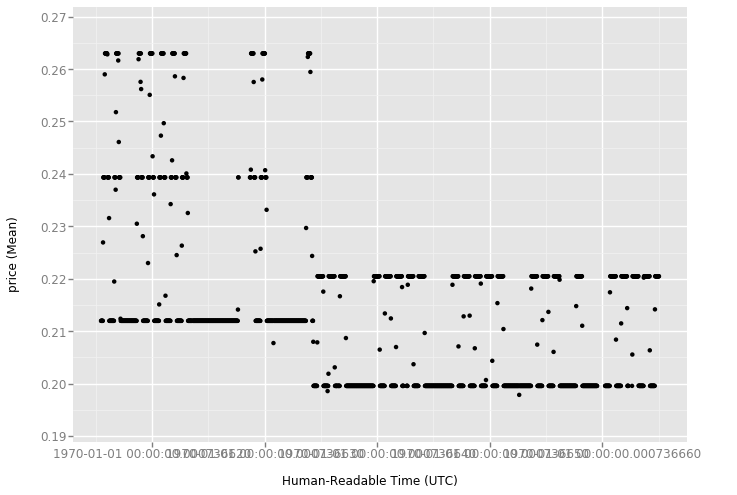

<ggplot: (-9223372036572189885)>

In [10]:
from ggplot import *
ggplot(df, aes(x = 'Human-Readable Time (UTC)',\
               y = 'price (Mean)')) + geom_point()

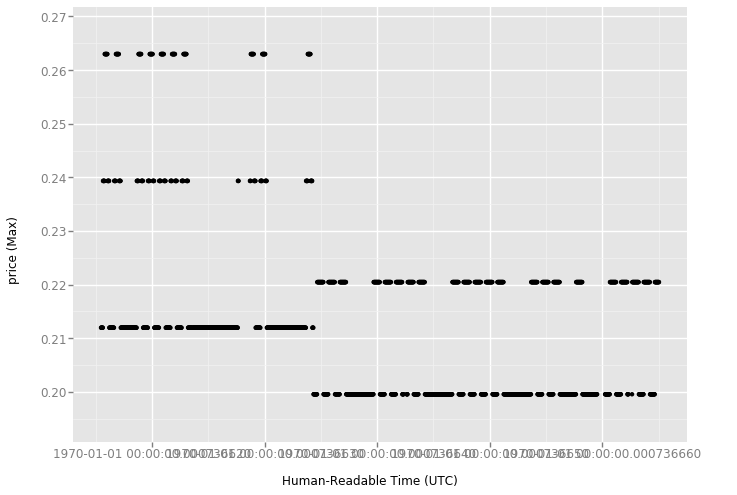

<ggplot: (-9223372036572189850)>

In [11]:
from ggplot import *
ggplot(df, aes(x = 'Human-Readable Time (UTC)',\
               y = 'price (Max)')) + geom_point()

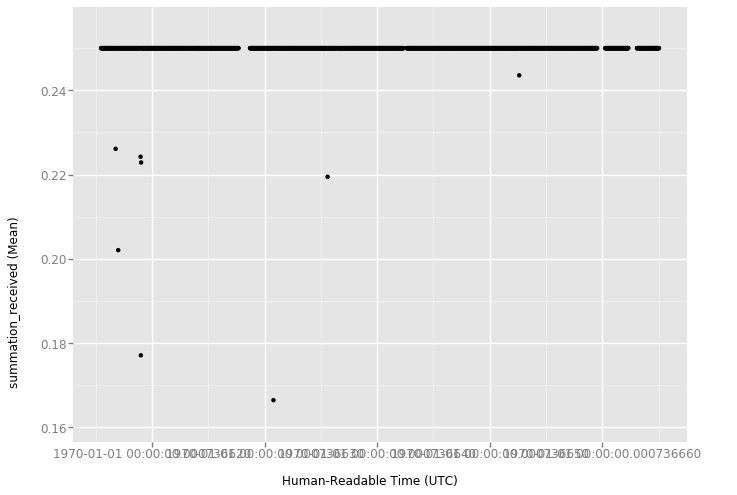

<ggplot: (-9223372036570928857)>

In [13]:
from ggplot import *
ggplot(df, aes(x = 'Human-Readable Time (UTC)',\
               y = 'summation_received (Mean)')) + geom_point()

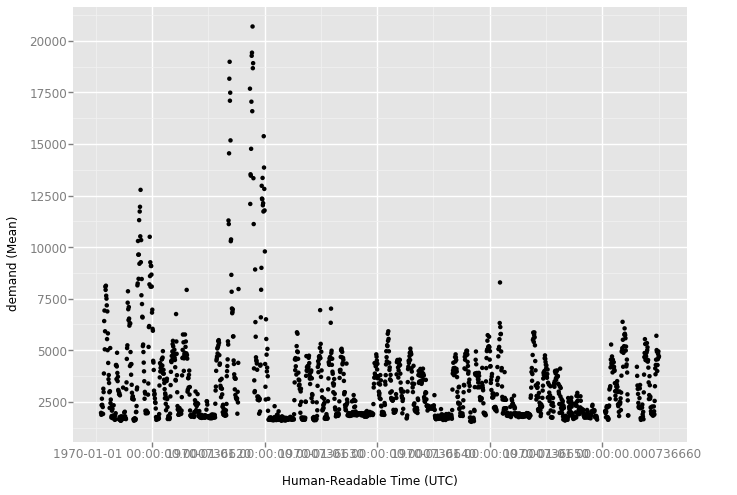

<ggplot: (-9223372036578578863)>

In [15]:
from ggplot import *
ggplot(df, aes(x = 'Human-Readable Time (UTC)',\
               y = 'demand (Mean)')) + geom_point()

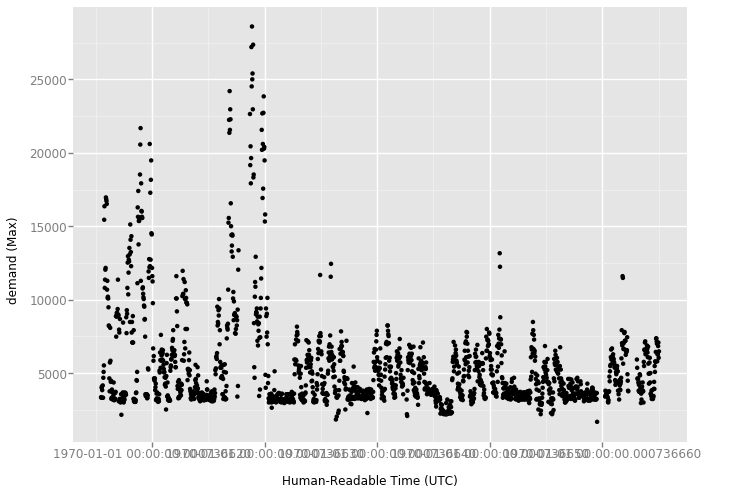

<ggplot: (285245718)>

In [16]:
from ggplot import *
ggplot(df, aes(x = 'Human-Readable Time (UTC)',\
               y = 'demand (Max)')) + geom_point()

In [20]:
# Updates every 36 minutes, so that should be our splits